### 1. Load up datasets for 3 months
This project will be using the first quarter 2024 data. 

In [19]:
# Load parquet file into dataframe
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor

Reuseable function to load required columns from parquet file

In [20]:
# Load file and ensure columns are in format to ease processing
def process_parquet(parquet_file_path, sample_frac=0.011):
    columns_needed = ['request_datetime', 'on_scene_datetime', 'PULocationID', 'DOLocationID', 'trip_time']

    # Read the specific columns
    df = pd.read_parquet(parquet_file_path, columns=columns_needed)
    
    # Sample a fraction of the dataframe to reduce memory usage and make processing faster
    sampled_df = df.sample(frac=sample_frac)
    
    # Convert datetime columns
    sampled_df['request_datetime'] = pd.to_datetime(sampled_df['request_datetime'])
    sampled_df['on_scene_datetime'] = pd.to_datetime(sampled_df['on_scene_datetime'])

    # Convert to second precision to save memory
    sampled_df['request_datetime'] = sampled_df['request_datetime'].values.astype('datetime64[s]')
    sampled_df['on_scene_datetime'] = sampled_df['on_scene_datetime'].values.astype('datetime64[s]')

    # Convert int64 to int32
    sampled_df['trip_time'] = sampled_df['trip_time'].astype('int32')
    
    # Calculate the wait_time in seconds
    sampled_df['wait_time'] = (sampled_df['on_scene_datetime'] - sampled_df['request_datetime']).dt.total_seconds()
    sampled_df['wait_time'] = sampled_df['wait_time'].astype('float32')
    
    return sampled_df

In [21]:
# Jan 2024
trip_jan = process_parquet('data/fhvhv_tripdata_2024-01.parquet')
trip_jan.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
17337286,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0
3084864,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0
3460416,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0
11230374,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0
13505552,2024-01-22 10:42:06,NaT,191,9,974,NaN


In [22]:
# Feb 2024
trip_feb = process_parquet('data/fhvhv_tripdata_2024-02.parquet') 
trip_feb.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
17595017,2024-02-27 13:05:25,NaT,143,48,336,NaN
2446035,2024-02-04 11:04:31,2024-02-04 11:09:08,255,255,160,277.0
15547023,2024-02-24 10:45:15,2024-02-24 10:46:56,170,137,315,101.0
17187583,2024-02-26 18:53:04,2024-02-26 18:56:16,170,188,2485,192.0
11608800,2024-02-18 02:08:23,2024-02-18 02:14:30,92,53,777,367.0


In [23]:
# Mar 2024
trip_mar = process_parquet('data/fhvhv_tripdata_2024-03.parquet') 
trip_mar.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
18235517,2024-03-27 18:01:35,2024-03-27 18:09:34,85,89,387,479.0
3720029,2024-03-06 10:26:35,2024-03-06 10:30:02,237,163,642,207.0
6409379,2024-03-09 21:30:58,2024-03-09 21:36:18,167,119,838,320.0
9919770,2024-03-15 10:04:11,2024-03-15 10:15:59,48,132,4305,708.0
8326085,2024-03-12 21:08:58,NaT,123,165,539,NaN


In [24]:
# Merge the three dataframes, ensure the merge is optimised
trips = pd.concat([trip_jan, trip_feb, trip_mar], ignore_index=True)

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0
1,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0
2,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0
3,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0
4,2024-01-22 10:42:06,NaT,191,9,974,NaN


In [25]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663343 entries, 0 to 663342
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   663343 non-null  datetime64[s]
 1   on_scene_datetime  489400 non-null  datetime64[s]
 2   PULocationID       663343 non-null  int32        
 3   DOLocationID       663343 non-null  int32        
 4   trip_time          663343 non-null  int32        
 5   wait_time          489400 non-null  float32      
dtypes: datetime64[s](2), float32(1), int32(3)
memory usage: 20.2 MB


### 2. Data Exploration

In [26]:
# Shape of dataframe
trips.shape

(663343, 6)

In [27]:
trips.describe()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
count,663343,489400,663343.000000,663343.000000,663343.000000,489400.000000
mean,2024-02-16 10:35:50,2024-02-16 14:03:38,138.706413,141.853344,1149.068851,191.532532
min,2023-12-31 23:54:03,2023-12-31 23:59:19,2.000000,1.000000,1.000000,-4007.000000
25%,2024-01-24 22:43:02,2024-01-25 09:17:31,75.000000,75.000000,584.000000,96.000000
50%,2024-02-16 18:55:50,2024-02-16 19:03:21,140.000000,141.000000,939.000000,163.000000
75%,2024-03-09 17:01:35,2024-03-09 19:37:23,210.000000,216.000000,1479.000000,259.000000
max,2024-03-31 23:58:30,2024-03-31 23:58:55,265.000000,265.000000,26008.000000,7464.000000
std,NaN,NaN,74.879728,77.768001,807.422903,190.088562


In [28]:
# Check for nulls
trips.isnull().sum()

request_datetime          0
on_scene_datetime    173943
PULocationID              0
DOLocationID              0
trip_time                 0
wait_time            173943
dtype: int64

In [29]:
# Drop nulls there is more than enough data
trips = trips.dropna()
trips.shape

(489400, 6)

<Axes: xlabel='wait_time'>

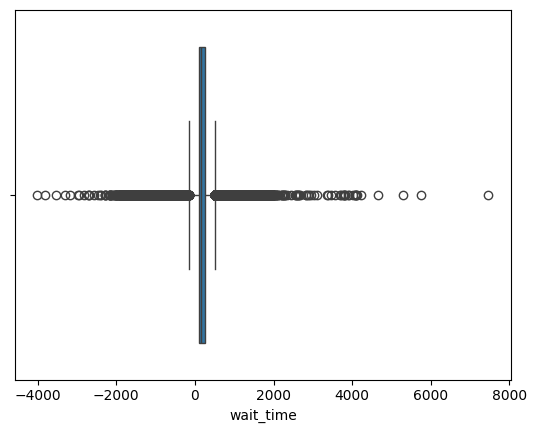

In [30]:
# Wait time seems to have some negative values from the min. Using boxplot to investigate more
sns.boxplot(x=trips['wait_time'])

In [31]:
# Get the count of negative wait times.
trips[trips['wait_time'] < 0]['wait_time'].count()

4412

In [32]:
# Drop negative wait times
trips = trips[trips['wait_time'] >= 0]

trips.shape

(484988, 6)

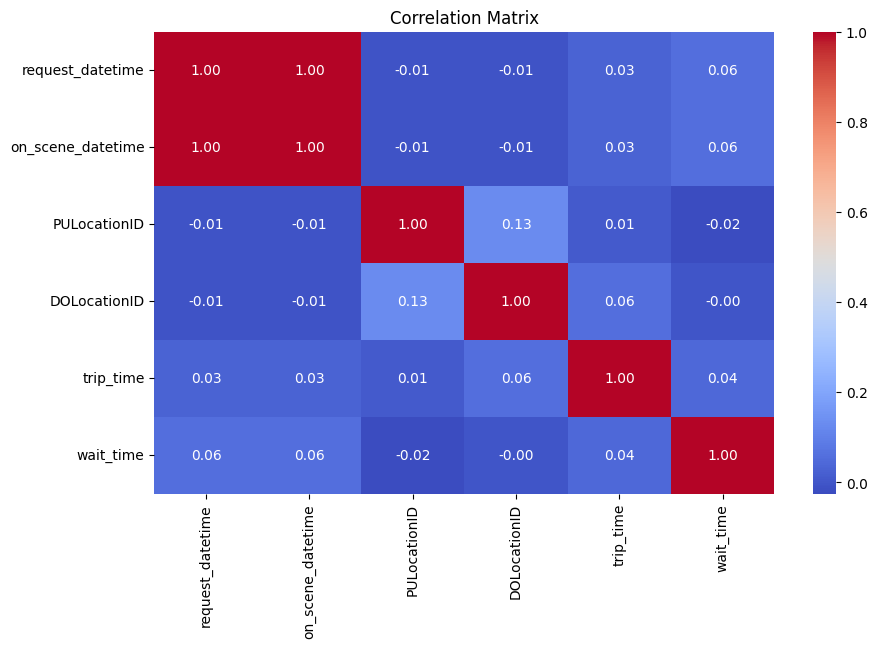

In [33]:
# understand the relationship between variables
plt.figure(figsize=(10, 6))
sns.heatmap(trips.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### 3.0. Feature Selection (add external data)
#### 3.1. Add Holidays in NYC data

In [34]:
# Holidays
from datetime import date
import holidays

ny_holidays = holidays.country_holidays('US', subdiv='NY', years=2024)

# Load ny_holidays into dataframe, date and holiday name
ny_holidays_df = pd.DataFrame.from_dict(ny_holidays, orient='index')
ny_holidays_df

,0
2024-01-01,New Year's Day
2024-05-27,Memorial Day
2024-06-19,Juneteenth National Independence Day
2024-07-04,Independence Day
2024-09-02,Labor Day
2024-11-11,Veterans Day
2024-11-28,Thanksgiving
2024-12-25,Christmas Day
2024-01-15,Martin Luther King Jr. Day
2024-02-19,Washington's Birthday


In [35]:
# Reset index and rename columns
ny_holidays_df.reset_index(inplace=True)
ny_holidays_df.columns = ['date', 'holiday_name']
ny_holidays_df

,date,holiday_name
0,2024-01-01,New Year's Day
1,2024-05-27,Memorial Day
2,2024-06-19,Juneteenth National Independence Day
3,2024-07-04,Independence Day
4,2024-09-02,Labor Day
5,2024-11-11,Veterans Day
6,2024-11-28,Thanksgiving
7,2024-12-25,Christmas Day
8,2024-01-15,Martin Luther King Jr. Day
9,2024-02-19,Washington's Birthday


In [36]:
# Convert holidays to datetime and create is_holiday flag in the trips dataframe
ny_holidays_df.index = pd.to_datetime(ny_holidays_df.index)
ny_holidays_df['date'].values.astype('datetime64[s]')
trips['is_holiday'] = trips['request_datetime'].dt.date.isin(ny_holidays_df['date']).astype(int)
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday
0,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0,0
1,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0,0
2,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0,0
3,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0,0
5,2024-01-26 15:59:33,2024-01-26 16:01:40,230,230,335,127.0,0


In [37]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484988 entries, 0 to 663342
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   484988 non-null  datetime64[s]
 1   on_scene_datetime  484988 non-null  datetime64[s]
 2   PULocationID       484988 non-null  int32        
 3   DOLocationID       484988 non-null  int32        
 4   trip_time          484988 non-null  int32        
 5   wait_time          484988 non-null  float32      
 6   is_holiday         484988 non-null  int32        
dtypes: datetime64[s](2), float32(1), int32(4)
memory usage: 20.4 MB


#### 3.2. Add Time Based Features

In [38]:
# Hour of the day, day of the week, month, year
trips['hour'] = trips['request_datetime'].dt.hour
trips['week_day'] = trips['request_datetime'].dt.weekday
trips['month'] = trips['request_datetime'].dt.month

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month
0,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0,0,3,6,1
1,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0,0,12,5,1
2,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0,0,21,5,1
3,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0,0,7,4,1
5,2024-01-26 15:59:33,2024-01-26 16:01:40,230,230,335,127.0,0,15,4,1


In [39]:
# Define total trip time
trips['total_trip_time'] = trips['wait_time'] + trips['trip_time']
trips['total_trip_time'] = trips['wait_time'].astype('float32')
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time
0,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0,0,3,6,1,288.0
1,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0,0,12,5,1,199.0
2,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0,0,21,5,1,153.0
3,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0,0,7,4,1,246.0
5,2024-01-26 15:59:33,2024-01-26 16:01:40,230,230,335,127.0,0,15,4,1,127.0


In [40]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484988 entries, 0 to 663342
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   484988 non-null  datetime64[s]
 1   on_scene_datetime  484988 non-null  datetime64[s]
 2   PULocationID       484988 non-null  int32        
 3   DOLocationID       484988 non-null  int32        
 4   trip_time          484988 non-null  int32        
 5   wait_time          484988 non-null  float32      
 6   is_holiday         484988 non-null  int32        
 7   hour               484988 non-null  int32        
 8   week_day           484988 non-null  int32        
 9   month              484988 non-null  int32        
 10  total_trip_time    484988 non-null  float32      
dtypes: datetime64[s](2), float32(2), int32(7)
memory usage: 27.8 MB


#### 3.3. Group into Peak, off-peak and night time

In [41]:
""" 
    Group request datetime into Peak, Off-Peak and Night
    Night: 10pm to 6am
    Off-Peak: Weekdays, 10am to 3pm and 7pm to 10pm. Weekends, 6am to 10pm
    Peak: Weekdays, 6am to 10am and 3pm to 7pm
"""

# Extract hour and day of week
hour = trips['hour']
week_day = trips['week_day']

# is holiday
is_holiday = trips['is_holiday'].astype(bool)

# Initialize the default group as Night (0)
trips['request_time_group'] = 0

# Define conditions for Peak (2) and OffPeak (1) times for weekday
weekday_mask = week_day < 5

peak_mask = (hour >= 6) & (hour < 10) | (hour >= 15) & (hour < 19)
off_peak_mask = (hour >= 10) & (hour < 15) | (hour >= 19) & (hour < 22)

# For weekend
weekend_mask = ~weekday_mask

# Apply conditions for weekdays
# Pandas is built to work efficiently with data in a vectorized way, meaning it can operate on entire columns (or Series) of data at once without needing an explicit loop
# .loc leverages the underlying numpy array to apply the mask to the dataframe without iterating over rows one by one
# note that all day during holidays are Off-Peak

# If day is not holiday, it will be Peak
trips.loc[weekday_mask & peak_mask & ~is_holiday, 'request_time_group'] = 2
# If day is holiday, it will be Off-Peak
trips.loc[weekday_mask & peak_mask & is_holiday, 'request_time_group'] = 1

trips.loc[weekday_mask & off_peak_mask, 'request_time_group'] = 1

# Apply conditions for weekends
trips.loc[weekend_mask & (hour >= 6) & (hour < 22), 'request_time_group'] = 1

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
0,2024-01-28 03:11:18,2024-01-28 03:16:06,50,1,3031,288.0,0,3,6,1,288.0,0
1,2024-01-06 12:05:11,2024-01-06 12:08:30,249,87,849,199.0,0,12,5,1,199.0,1
2,2024-01-06 21:19:24,2024-01-06 21:21:57,231,230,1252,153.0,0,21,5,1,153.0,1
3,2024-01-19 07:54:22,2024-01-19 07:58:28,91,89,515,246.0,0,7,4,1,246.0,2
5,2024-01-26 15:59:33,2024-01-26 16:01:40,230,230,335,127.0,0,15,4,1,127.0,2


In [42]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484988 entries, 0 to 663342
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    484988 non-null  datetime64[s]
 1   on_scene_datetime   484988 non-null  datetime64[s]
 2   PULocationID        484988 non-null  int32        
 3   DOLocationID        484988 non-null  int32        
 4   trip_time           484988 non-null  int32        
 5   wait_time           484988 non-null  float32      
 6   is_holiday          484988 non-null  int32        
 7   hour                484988 non-null  int32        
 8   week_day            484988 non-null  int32        
 9   month               484988 non-null  int32        
 10  total_trip_time     484988 non-null  float32      
 11  request_time_group  484988 non-null  int64        
dtypes: datetime64[s](2), float32(2), int32(7), int64(1)
memory usage: 31.5 MB


In [43]:
# Drop unneeded columns
trips.drop(['on_scene_datetime'], axis=1, inplace=True)

trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
0,2024-01-28 03:11:18,50,1,3031,288.0,0,3,6,1,288.0,0
1,2024-01-06 12:05:11,249,87,849,199.0,0,12,5,1,199.0,1
2,2024-01-06 21:19:24,231,230,1252,153.0,0,21,5,1,153.0,1
3,2024-01-19 07:54:22,91,89,515,246.0,0,7,4,1,246.0,2
5,2024-01-26 15:59:33,230,230,335,127.0,0,15,4,1,127.0,2


In [44]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484988 entries, 0 to 663342
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    484988 non-null  datetime64[s]
 1   PULocationID        484988 non-null  int32        
 2   DOLocationID        484988 non-null  int32        
 3   trip_time           484988 non-null  int32        
 4   wait_time           484988 non-null  float32      
 5   is_holiday          484988 non-null  int32        
 6   hour                484988 non-null  int32        
 7   week_day            484988 non-null  int32        
 8   month               484988 non-null  int32        
 9   total_trip_time     484988 non-null  float32      
 10  request_time_group  484988 non-null  int64        
dtypes: datetime64[s](1), float32(2), int32(7), int64(1)
memory usage: 27.8 MB


#### 3.4. NYC weather

In [45]:
# Get Weather data
from datetime import datetime 
from meteostat import Point, Hourly, units  
# Set time period 
start = datetime(2024, 1, 1) 
end = datetime(2024, 3, 31)  
# Create Point for NY
location = Point(40.712775, -74.005973)  
# Get daily data 
weather_data = Hourly(location, start, end) 
weather_data = weather_data.convert(units.imperial) 
weather_data = weather_data.fetch()

weather_data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [46]:
# Reset index and convert time to datetime
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'index': 'time'}, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2,2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
3,2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
4,2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [47]:
# Create column to compare with weather time
trips['rounded_request_datetime'] = trips['request_datetime'].dt.round('H')

In [48]:
# Merge trips and weather dataframe on trips[rounded_request_datetime] and weather[time]
trips = trips.merge(weather_data, left_on='rounded_request_datetime', right_on='time', how='left')
trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-28 03:11:18,50,1,3031,288.0,0,3,6,1,288.0,...,37.9,82.0,0.000,NaN,150.0,7.0,NaN,1022.9,NaN,3.0
1,2024-01-06 12:05:11,249,87,849,199.0,0,12,5,1,199.0,...,24.8,69.0,0.000,NaN,70.0,5.8,NaN,1022.9,NaN,3.0
2,2024-01-06 21:19:24,231,230,1252,153.0,0,21,5,1,153.0,...,32.2,89.0,0.016,NaN,40.0,15.0,NaN,1014.0,NaN,12.0
3,2024-01-19 07:54:22,91,89,515,246.0,0,7,4,1,246.0,...,19.9,58.0,0.000,NaN,80.0,5.8,NaN,1014.5,NaN,3.0
4,2024-01-26 15:59:33,230,230,335,127.0,0,15,4,1,127.0,...,41.2,93.0,0.020,NaN,50.0,12.7,NaN,1016.4,NaN,8.0


In [49]:
# Remove unneeded columns
trips.drop(['request_datetime', 'rounded_request_datetime', 'trip_time', 'time', 'dwpt', 'rhum', 'wait_time', 'prcp','snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'temp'], axis=1, inplace=True)

In [50]:
# Change data types
trips['request_time_group'] = trips['request_time_group'].astype('int32')
trips['coco'] = trips['coco'].astype('float32')

# Rename coco to weather_condition_code  
trips.rename(columns={'coco': 'weather_condition_code'}, inplace=True)

In [51]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484988 entries, 0 to 484987
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PULocationID            484988 non-null  int32  
 1   DOLocationID            484988 non-null  int32  
 2   is_holiday              484988 non-null  int32  
 3   hour                    484988 non-null  int32  
 4   week_day                484988 non-null  int32  
 5   month                   484988 non-null  int32  
 6   total_trip_time         484988 non-null  float32
 7   request_time_group      484988 non-null  int32  
 8   weather_condition_code  479846 non-null  float32
dtypes: float32(2), int32(7)
memory usage: 16.7 MB


In [52]:
# Check for null values
trips.isnull().sum()

PULocationID                 0
DOLocationID                 0
is_holiday                   0
hour                         0
week_day                     0
month                        0
total_trip_time              0
request_time_group           0
weather_condition_code    5142
dtype: int64

In [53]:
# Drop null values
trips.dropna(inplace=True)

In [54]:
# Check for null values
trips.isnull().sum()

PULocationID              0
DOLocationID              0
is_holiday                0
hour                      0
week_day                  0
month                     0
total_trip_time           0
request_time_group        0
weather_condition_code    0
dtype: int64

In [55]:
# Check dataset shape
trips.shape

(479846, 9)

### 4.0. More EDA

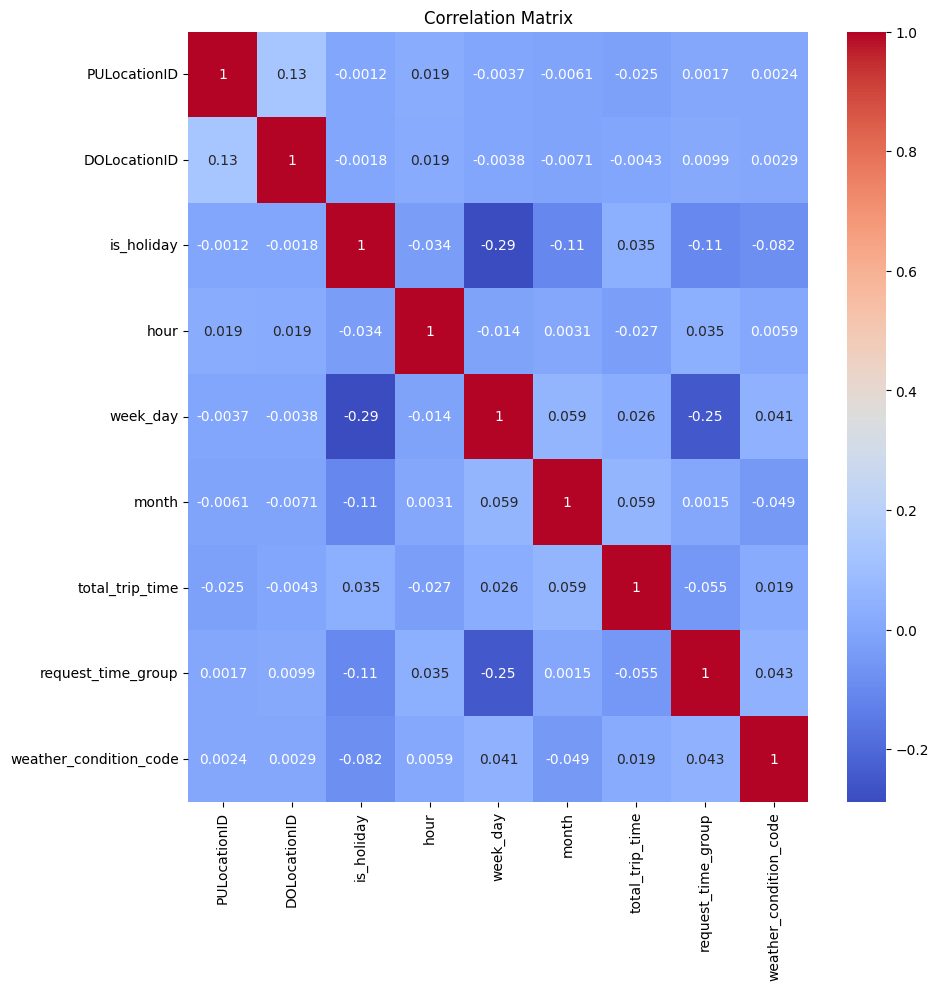

In [56]:
#correlation heatmap, to check correlation between different variables
#results range from -1 to 1 where 1 is perfect correlation and -1 is perfect negative correlation
correlation_matrix = trips.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [57]:
trips.head()

,PULocationID,DOLocationID,is_holiday,hour,week_day,month,total_trip_time,request_time_group,weather_condition_code
0,50,1,0,3,6,1,288.0,0,3.0
1,249,87,0,12,5,1,199.0,1,3.0
2,231,230,0,21,5,1,153.0,1,12.0
3,91,89,0,7,4,1,246.0,2,3.0
4,230,230,0,15,4,1,127.0,2,8.0


In [58]:
#rounding up columns ans converting to int32
trips['total_trip_time'] = np.ceil(trips['total_trip_time']).astype('int32')
trips['weather_condition_code'] = np.ceil(trips['weather_condition_code']).astype('int32')

trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479846 entries, 0 to 484987
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   PULocationID            479846 non-null  int32
 1   DOLocationID            479846 non-null  int32
 2   is_holiday              479846 non-null  int32
 3   hour                    479846 non-null  int32
 4   week_day                479846 non-null  int32
 5   month                   479846 non-null  int32
 6   total_trip_time         479846 non-null  int32
 7   request_time_group      479846 non-null  int32
 8   weather_condition_code  479846 non-null  int32
dtypes: int32(9)
memory usage: 20.1 MB


#### 4.1 Visualisations to further analyse relationships

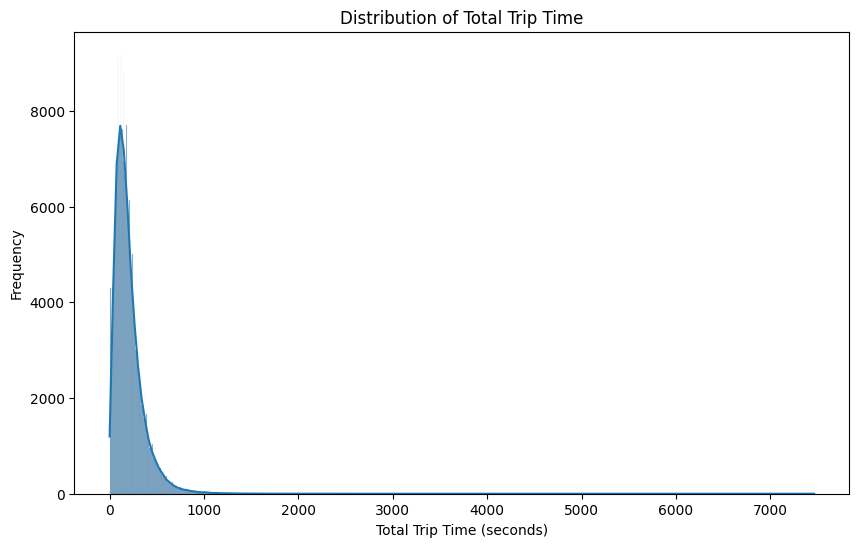

In [59]:
# Distribution of total_trip_time
plt.figure(figsize=(10, 6))
sns.histplot(trips['total_trip_time'], kde=True)
plt.title('Distribution of Total Trip Time')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

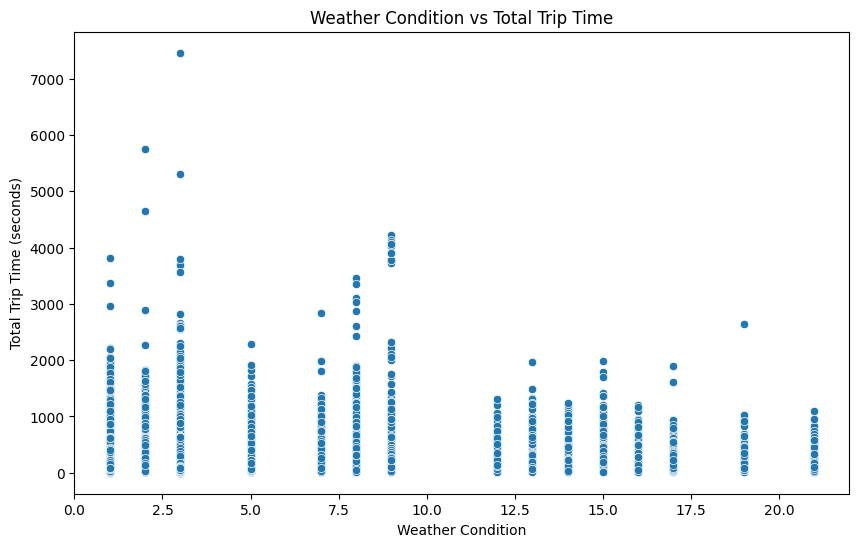

In [60]:
# Scatter plot of weather_condition_code vs total_trip_time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weather_condition_code', y='total_trip_time', data=trips)
plt.title('Weather Condition vs Total Trip Time')
plt.xlabel('Weather Condition')
plt.ylabel('Total Trip Time (seconds)')
plt.show()


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



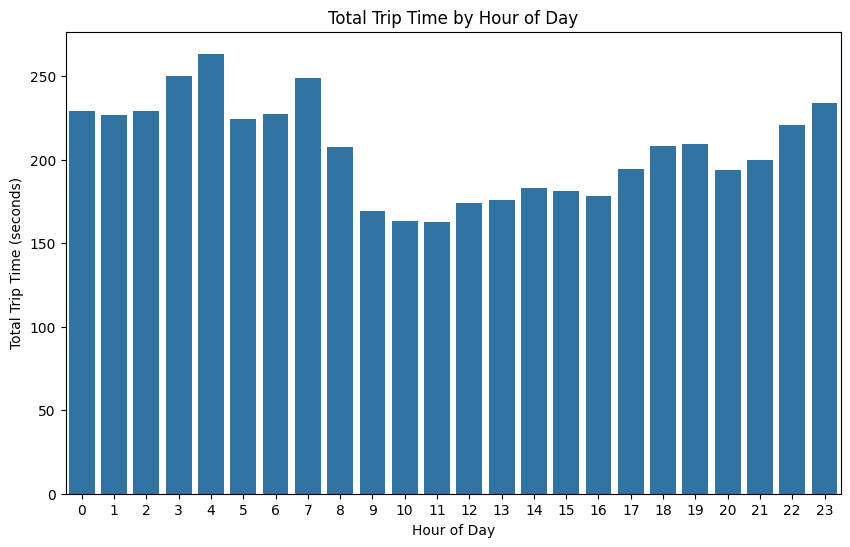

In [61]:
# total_trip_time by hour
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='total_trip_time', data=trips, errorbar=None)
plt.title('Total Trip Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

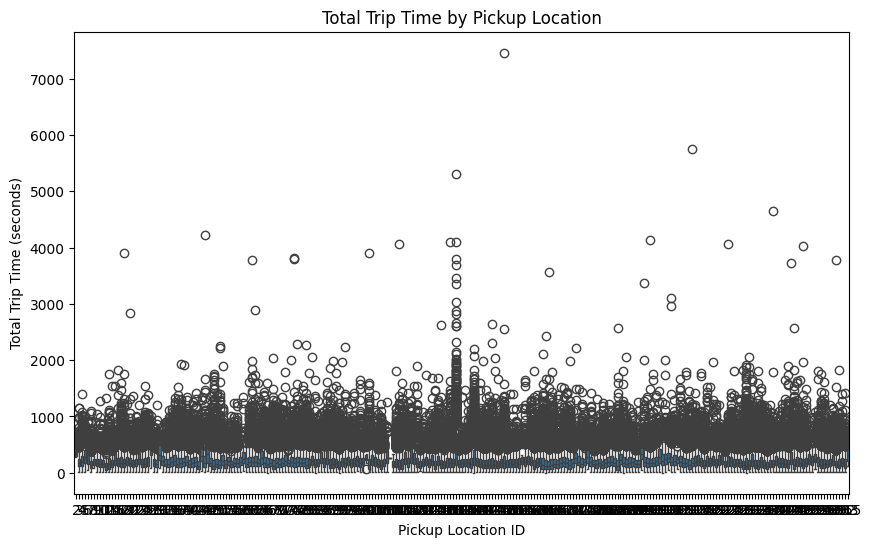

In [62]:
# total_trip_time by PULocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='PULocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

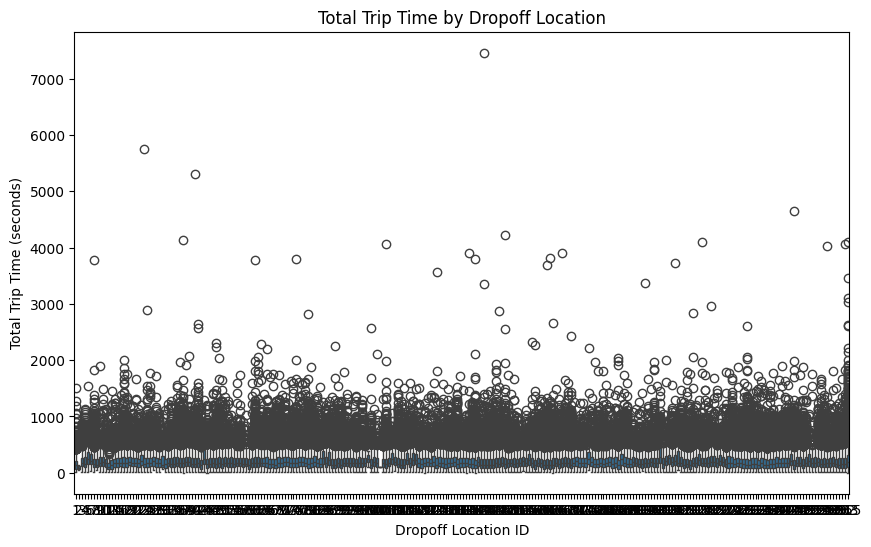

In [63]:
# total_trip_time by DOLocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='DOLocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

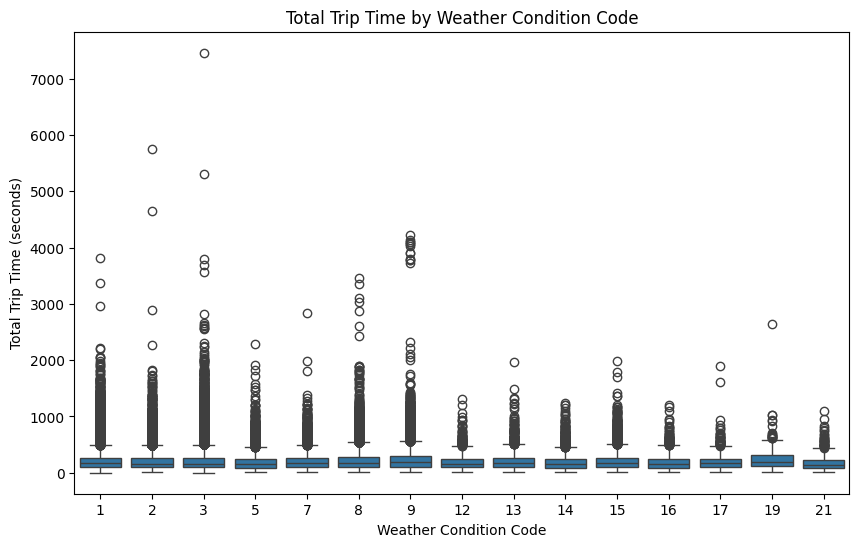

In [64]:
# Box plot of total_trip_time by weather_condition_code
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_condition_code', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Weather Condition Code')
plt.xlabel('Weather Condition Code')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

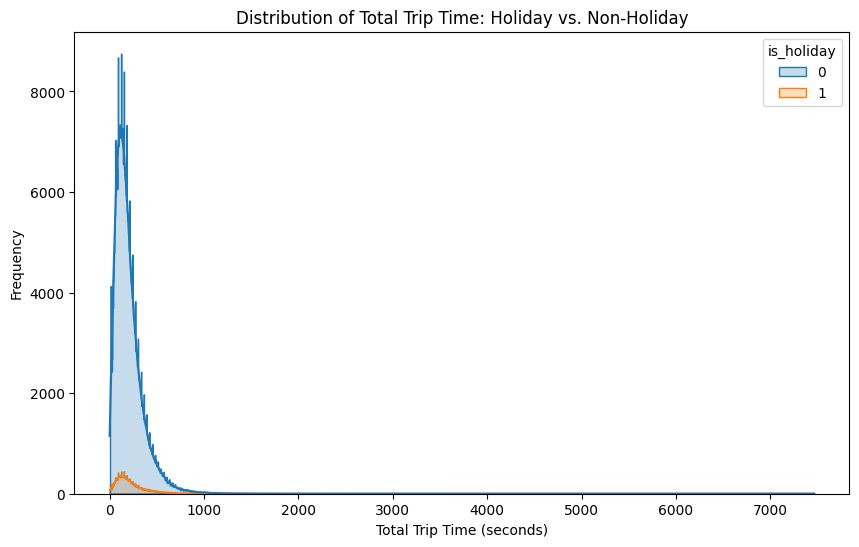

In [66]:
# Distribution of total_trip_time on holidays vs. non-holidays
plt.figure(figsize=(10, 6))
sns.histplot(data=trips, x='total_trip_time', hue='is_holiday', kde=True, element='step')
plt.title('Distribution of Total Trip Time: Holiday vs. Non-Holiday')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



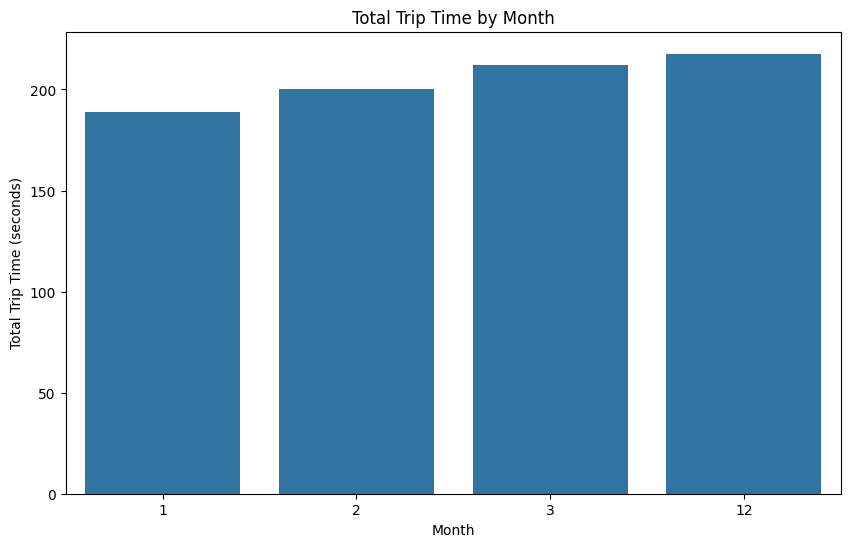

In [67]:
#analyze how the total_trip_time changes across different months, which might reveal seasonal patterns
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_trip_time', data=trips, ci=None)
plt.title('Total Trip Time by Month')
plt.xlabel('Month')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

### 5.0 Machine Learning Models
#### 5.1 Linear Regression

In [69]:
""" 
From the correlation Matrix, there is a low correlation/weak linear relationship between total_trip_time and the other variables. This suggest the use of complex models to capture the non-linear relationship.

Starting with a simple linear regression model, even though the correlation is low, the model is able to give a baseline comparison.
"""

# Define features and target
X = trips.drop('total_trip_time', axis=1)
y = trips['total_trip_time']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Absolute Error: 109.97208572190868
Mean Squared Error: 24383.051135096794
R-squared: 0.010058552149424305


In [70]:
#save model to pickle
import pickle

pickle.dump(lr_model, open('lr_model.pkl', 'wb'))


#### 5.2. Random Forest

In [71]:
# RF can capture complex non-linear relationships
# Random Forest Regression
rf_model = RandomForestRegressor(max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Absolute Error: 109.1983392044537
Mean Squared Error: 24073.146023657686
R-squared: 0.022640567132476863


#### 5.3. LightGBM

In [72]:
# LGBM can capture complex non-linear relationships
# LightGBM Regression
lgbm_model = LGBMRegressor(random_state=0)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 383876, number of used features: 8
[LightGBM] [Info] Start training from score 200.673996
Mean Absolute Error: 102.36493285608186
Mean Squared Error: 21464.781142396983
R-squared: 0.12853906575642948


#### 5.4. SVM

In [73]:
# SVM can capture complex non-linear relationships
# Support Vector Regression

#standardize the data
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)

#create the model
svm = svm.SVC(kernel = 'rbf')
svm.fit(X_train1, y_train)

#predict on the train set and test set
y_train_pred = svm.predict(X_train1)
y_test_pred = svm.predict(X_test1)

#evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))